<a href="https://colab.research.google.com/github/siwookim1114/Deep-Learning-with-Keras-and-TensorFlow/blob/main/Ch4_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EC%8B%9C%EC%9E%91%ED%95%98%EA%B8%B0_%EB%B6%84%EB%A5%98%EC%99%80_%ED%9A%8C%EA%B7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 영화 리뷰 분류 : 이진 분류 문제
* 리뷰 텍스트를 기반으로 영화 기뷰를 긍정 (positive) / 부정 (negative)으로 분류하기

## IMDB 데이터셋
* 데이터는 전처리되어 잇어 각 리뷰 (단어 시퀀스)가 숫자 시퀀스로 변환되어 있음

### 데이터셋 로드하기

In [ ]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)  ## num_words = 10000 : 훈련 데이터에서 가장 자주 나타나는 단어 1만 개만 사용 (드물게 나타나는 단어는 무시)

## train-data, train_labels => 리뷰를 담은 배열 (각 리뷰는 단어 인덱스의 리스트 (단어 시퀀스가 인코딩 됨))
## train_labels와 test_labels: 0 (부정) 과 1 (긍정) 을 담은 리스트

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 리뷰를 다시 텍스트로 디코딩

In [ ]:
word_index = imdb.get_word_index()  ## word_index()는 단어와 정수 인덱스를 매핑한 딕셔너리
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])  ## 정수 인덱스와 단어를 매핑하도록 뒤집음
decoded_review = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])  ## 리뷰를 디코딩함. 0, 1, 2 는 패딩, 문서 시작, 사전에 없음을 위해 예약, 그래서 인덱스에서 3을 뺌

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 데이터 준비
* 신경망에 숫자 리스트를 바로 주입 X => 숫자 리스트는 모두 길이가 다르지만 신경망은 동일한 크기의 배치를 기대하기 때문
    * 리스트를 텐서로 바꿔야됨
        * 같은 길이가 되도록 리스트에 padding을 추가하고 (samples, max_length) 크기의 정수 텐서로 변환 -> 정수 텐서를 다룰 수 있는 층으로 신경망을 시작 (embedding)
    * 리스트를 멀티 - 핫 인코딩 (multi-hot encoding) 하여 0과 1의 벡터로 변환.
        * e.g) [8,5] 를 인덱스 8과 5의 위치는 1, 그 외는 모두 0 인 10000차원의 벡터로 각각 변환 -> 그 다음 부동 소수점 벡터 데이터를 다룰 수 있는 Dense층을 신경망의 첫번째 층으로 사용

### 정수 시퀀스를 멀티-핫 인코딩으로 인코딩

In [ ]:
## Multi-Hot Encoding 방법 사용
import numpy as np

def vectorize_sequences(sequences, dimension = 10000):
  results = np.zeros((len(sequences), dimension))        ## 크기가 (len(sequences), dimension)이고 모든 원소가 0인 행렬을 만듬
  for i , sequence in enumerate(sequences):
    for j in sequence:
      results[i, j] = 1.          ## results[i] 에서 특정 인덱스의 위치를 1로 만듬
  return results

x_train = vectorize_sequences(train_data)   ## 훈련 데이터를 벡터로 변환
x_test = vectorize_sequences(test_data)     ## 테스트 데이터를 벡터로 변환

In [ ]:
## 데이터 확인
x_train[0]

## 레이블 변경
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

## 신경망 모델 만들기
* 입력 데이터: 벡터, 레이블: 스칼라 (1 또는 0) => 잘 작동하는 모델 : ReLU 활성화 함수를 사용한 Dense Layer 연결
* Dense 층 쌓을때 중요한 구조상 결정:
    * 얼마나 많은 층 사용?
    * 각층에 얼마나 많은 유닛?

* 당분간 다음 구조 사용:
    * 2개의 중간층 + 각 16개의 유닛
    * 리뷰의 감정을 스칼라 값의 예측으로 출력하는 output layer

### 모델 정의
* Dense 층에 전달한 첫번째 파라미터 => 층의 unit 개수
    * 층이 가진 표현 공간 (representation space)의 차원
* relu 활성화 함수를 사용한 Dense층: output = relu(dot(W, input) + b)
    * 16개의 유닛 : 가중치 행렬 W의 크기가 (input_dimension, 16) => 입력 데이터와 W를 dot product => 입력 데이터가 16차원으로 표현된 공간으로 투영됨
    * 표현 공간의 차원은 "모델이 내재된 표현을 학습할 때 가질 수 있는 자유도"
        * 유닛 늘리면 (표현 공간이 더 고차원) -> 모델이 더욱 복잡한 표현 학습 가능하지만 계산 비용 커지고 원하지 않은 패턴 학습 할 수 있음 (overfitting)
* 중간층 활성화 함수 ReLu, 마지막 층은 확률을 출력하기 위해 sigmoid 활성화 함수
    * 0과 1 사이의 점수 -> 어떤 샘플이 타깃 "1"일 가능성이 높다는 것은 그 리뷰가 긍정일 가능성이 높다는 것을 의미
    * relu는 음수를 0으로 만드는 함수
    * 시그모이드는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률처럼 해석할 수 있음

* ReLU와 같은 활성화 함수 (비선형성(non-linear) 함수)가 없다면 Dense 층은 그냥 선형적인 연산인 점곱과 덧셈 2개로 구성 : output = dot(W, input) + b
    * 이 층은 입력에 대한 선형 변환 (아핀 변환)만 학습 가능
    * 층의 가설 공간은 입력 데이터를 16차원의 공간으로 바꾸는 가능한 모든 선형 변환의 집합
    * 이런 가설 공간은 매우 제약이 많으며 선형 층을 깊게 쌓아도 여전히 하나의 선형 연산이기 때문에 층을 여러 개로 구성하는 장점이 X => 층을 깊게 만드는 장점을 살리기 위해서는 비선형성 또는 활성화 함수를 추가해야됨
    

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation = "relu"),   ## First hidden layer
    layers.Dense(16, activation = "relu"),   ## Second hidden layer
    layers.Dense(1, activation = "sigmoid")  ## Output layer
])

### 모델 컴파일
* 손실 함수와 옵티마이저 선택
    * 손실함수
        * 이진 분류 문제 (모델 출력이 확률 => 시그모이드를 output layer로 하나의 유닛과) => BinaryCrossEntropy 손실이 적합
            * mean_squared_error도 사용 가능 하지만 확률을 출력하는 모델을 사용할때는 크로스엔트로피가 최선의 선택
            * 크로스엔트로피는 확률 분포 간의 차이를 측정 (원본 분포와 예측 분포 사이를 측정)
    * 옵티마이저
        * rmsprop 사용 (이 옵티마이저는 일반적으로 거의 모든 문제에 기본 선택으로 좋음)

In [ ]:
# rmsprop 옵티마이저와 binary_cross_entropy 손실 함수로 모델 설정
## 정확도를 사용하여 모니터링
model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

## 훈련 검증
* 딥러닝 모델은 훈련 데이터에서 평가 절대 X
    * 검증 세트를 사용하여 훈련 과정 중에 모델의 정확도를 모니터링 하는 것이 표준 관행
  

### 검증 세트 준비하기
* 원본 훈련 데이터에서 1만개의 샘플을 떼어 검증 세트로 만듬

In [ ]:
x_validation = x_train[:10000]   ## 인덱스 10000 바로 전까지 검증용
partial_x_train = x_train[10000:]  ## 나머지는 전체 - 10000 개의 데이터는 훈련용

y_validation = y_train[:10000]
partial_y_train = y_train[10000:]

### 모델 훈련하기
* 512개의 샘플씩 미니 배치 만들어 20번의 epoch동안 모델 훈련 (훈련 데이터에 있는 모든 샘플에 대해 20번 바복)
* 동시에 따로 떼어놓은 1만 개의 샘플에서 손실과 정확도를 측정 => validation_data 매개변수에 검증 데이터를 전달

In [ ]:
# 모델 훈련
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_validation, y_validation))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.7110 - loss: 0.5956 - val_accuracy: 0.8524 - val_loss: 0.4110
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8886 - loss: 0.3486 - val_accuracy: 0.8695 - val_loss: 0.3382
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9206 - loss: 0.2540 - val_accuracy: 0.8893 - val_loss: 0.2868
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9415 - loss: 0.1956 - val_accuracy: 0.8889 - val_loss: 0.2767
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9489 - loss: 0.1636 - val_accuracy: 0.8872 - val_loss: 0.2766
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9579 - loss: 0.1379 - val_accuracy: 0.8811 - val_loss: 0.2965
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9648 - loss: 0.1193 - val_accuracy: 0.8845 - val_loss: 0.3044
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9680 - loss: 0.1060 - val_accuracy: 0.8831 - 

에포크가 끝날 때마다 1만 개의 검증 샘플 데이터에서 손실과 정확도를 계산함

In [ ]:
## model.fit() 메서ㅕ드는 History 객체를 반환 => 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 history 딕셔너리 속성을 가지고 있음
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

딕셔너리는 훈련과 검증하는 동안 모니터링 할 측정 지표당 하나씩 모두 4개의 항목을 담고 있음.

### 훈련과 검증 손실 그리기
* 훈련과 검증 데이터에 대한 손실 그리기

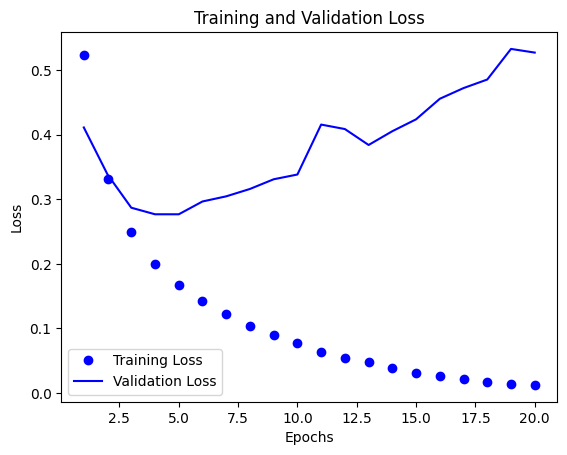

In [ ]:
import matplotlib.pyplot as plt

# 변수 설정
history_dict = history.history
loss_values = history_dict["loss"]
validation_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

# 그리기
plt.plot(epochs, loss_values, "bo", label = "Training Loss")    ## bo는 파란색 점
plt.plot(epochs, validation_loss_values, "b", label = "Validation Loss")    ## b는 파란색 실선
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

* 훈련 손실이 에포크마다 감소함. 경사 하강법 최적화를 사용하면 반복마다 최소화되는 것이 손실이므로 기대했던 대로 나옴.
* 검증 손실은 네번쨰 에코에서 그래프가 역전됨. 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에서는 잘 작동하지 않아서 그럼 => 과대적합 (Overfitting)
    * 네 번째 에포크 이후부터 훈련 데이터에 과도하게 최적화되어 훈련 데이터에 특화된 표현을 학습하므로 훈련 세트 이외의 데이터에는 일반화 되지 못함

### 훈련과 검증 정확도 그리기
* 훈련과 검증 데이터에 대한 정확도 그리기

<function matplotlib.pyplot.show(close=None, block=None)>

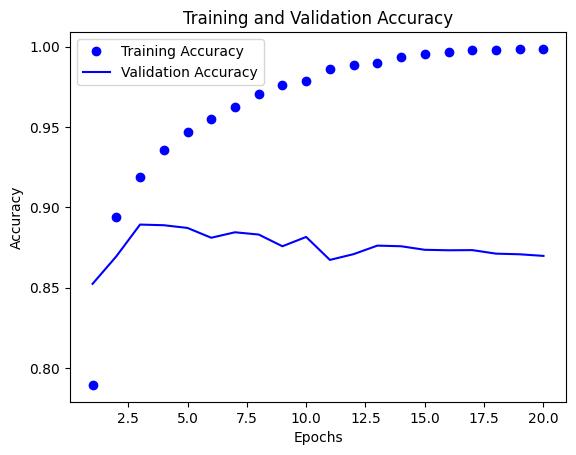

In [ ]:
plt.clf() ## 그리프 초기화

# 변수 설정
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

# 그리기
plt.plot(epochs, acc, "bo", label = "Training Accuracy")
plt.plot(epochs, val_acc, "b", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

* 훈련 정확도가 에포크마다 증가함
* 그러나 검증 정확도는 4번째 에포크부터 크게 증가 안하고 왔다갔다 하면서 조금씩 떨어짐 => Overfitting 문제

### 모델 처음부터 다시 훈련
* 과대적합을 방지하기 위해 네 번째 에포크 이후에 훈련을 중지 할 수 있음
* 처음부터 다시 새로운 신경망을 네 번의 에포크 동안만 훈련하고 테스트 데이터에서 평가

In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation = "relu"),
    layers.Dense(16, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])

model.compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

model.fit(x_train, y_train, epochs = 4, batch_size = 512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7246 - loss: 0.5671
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9017 - loss: 0.2892
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9225 - loss: 0.2165
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9407 - loss: 0.1766
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8841 - loss: 0.2918


In [ ]:
## 최종 결과
results

[0.2887725532054901, 0.8861200213432312]

첫번째 숫자 0.29는 테스트 손실, 두번째 숫자 0.88은 테스트 정확도
* 아주 단순한 방식으로 (역전되는 에포크까지만 훈련해서 끊어치기) 정확도 88% 달성
* 최고 수준의 기법 사용하면 95%에 가까운 성능 얻기 가능

## 훈련된 모델로 새로운 데이터에 대해 예측
* predict 메서드를 사용해서 어떤 리뷰가 긍정일 확률을 예측 가능




In [ ]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.26773265],
       [0.9997872 ],
       [0.8651388 ],
       ...,
       [0.13629146],
       [0.11874983],
       [0.663031  ]], dtype=float32)

## 정리
* 훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 과대적합 (Overfitting)되기 시작하고 이번에 본 적 없는 데이터에서는 결과가 점점 나빠짐
    * 항상 훈련 세트 이외의 데이터에서 성능을 모니터링 해야됨